In [1]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import pandas as pd
import numpy
# https://stackoverflow.com/questions/53562813/xgboost-cox-survival-time-entry

In [2]:
data = pd.read_csv("AIDSdata.csv")
# We drop `id` because it's just the identification number of each patient
# We exclude `time_d` and `censor_d` because these seem unfair to include 
#     in modeling since they contain information about time and censor
# We chose not to include `txgrp` and `strat2` because they were derived 
# (and thus highly correlated with) from other predictor variables. 
data = data.drop(['id', 'time_d', 'censor_d', 'txgrp', 'strat2', 'time_d'], axis=1)

In [25]:
data

,time,censor,tx,sex,raceth,ivdrug,hemophil,karnof,cd4,priorzdv,age
0,110,0,0,2,3,1,0,90,8.00000,9.0,16
1,88,0,0,1,2,1,0,90,37.00000,6.0,35
2,256,0,0,1,1,1,0,100,35.00000,11.0,29
3,259,0,0,1,3,3,0,90,12.00000,18.0,29
4,271,0,1,1,1,1,0,80,189.50000,11.0,31
5,193,0,0,1,3,1,0,100,171.00000,6.0,33
6,70,0,1,1,1,1,0,90,128.00000,74.0,42
7,200,0,1,2,2,1,0,90,87.50000,60.0,27
8,189,0,0,1,1,1,0,100,169.00000,39.0,34
9,87,1,0,1,2,1,0,80,8.00000,24.0,35


In [4]:
# We now separate predictors and labels
y = data[['time']]
X = data[['censor', 'tx', 'sex', 'raceth', 'ivdrug', 
          'hemophil', 'karnof', 'cd4', 'priorzdv', 'age']]

In [5]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
xgb_full = xgboost.DMatrix(X, label=y)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [7]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 10000, 
                            evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:4.17342
[1000]	test-cox-nloglik:4.10971
[2000]	test-cox-nloglik:4.13517
[3000]	test-cox-nloglik:4.16252
[4000]	test-cox-nloglik:4.20596
[5000]	test-cox-nloglik:4.24439
[6000]	test-cox-nloglik:4.27714
[7000]	test-cox-nloglik:4.31413
[8000]	test-cox-nloglik:4.35093
[9000]	test-cox-nloglik:4.38157
[9999]	test-cox-nloglik:4.41959


In [8]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:5.76902
[1000]	test-cox-nloglik:5.62279
[2000]	test-cox-nloglik:5.57787
[3000]	test-cox-nloglik:5.54371
[4000]	test-cox-nloglik:5.51498
[4999]	test-cox-nloglik:5.48894


In [10]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

In [13]:
# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test.to_numpy())

0.6111226395517743

In [14]:
# Explain the Model's Predictions on the Entire Dataset with SHAP values

In [15]:
shap_values = shap.TreeExplainer(model).shap_values(X)

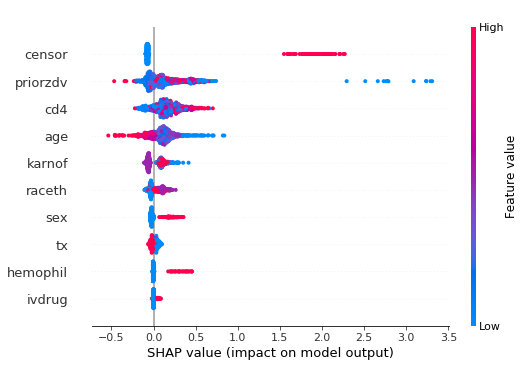

In [16]:
shap.summary_plot(shap_values, X)

In [17]:
X_display,y_display = shap.datasets.nhanesi(display=True)

In [21]:
X,y = shap.datasets.nhanesi()

In [23]:
y

array([ 15.27465753,  11.58607306,   8.14908676, ..., -18.87716895,
       -19.68310502,  17.93858447])

In [24]:
from sksurv.datasets import load_aids

ModuleNotFoundError: No module named 'sksurv'

In [32]:
X,y = shap.datasets.nhanesi()

In [12]:
y_test.to_numpy()

array([[ 56],
       [264],
       [284],
       [362],
       [169],
       [242],
       [300],
       [306],
       [250],
       [315],
       [311],
       [ 40],
       [280],
       [273],
       [149],
       [251],
       [313],
       [335],
       [276],
       [276],
       [256],
       [336],
       [132],
       [116],
       [283],
       [150],
       [298],
       [217],
       [315],
       [291],
       [297],
       [138],
       [313],
       [299],
       [224],
       [293],
       [ 55],
       [189],
       [250],
       [305],
       [285],
       [298],
       [104],
       [215],
       [333],
       [277],
       [271],
       [280],
       [326],
       [130],
       [291],
       [313],
       [284],
       [175],
       [348],
       [228],
       [313],
       [245],
       [  2],
       [257],
       [242],
       [315],
       [329],
       [259],
       [257],
       [329],
       [319],
       [335],
       [293],
       [278],
       [264],
      

In [34]:
y

array([ 15.27465753,  11.58607306,   8.14908676, ..., -18.87716895,
       -19.68310502,  17.93858447])